# SOA - TP3 - Parte 4

Este ejercicio se ha optado para aplicar 2 multidimensiones en GPU. El ejemplo modifica el color de una imagen parametrizada a escala de grises. El cálculo de la escala se realiza convirtiendo los 3 canales RGB, que representan a los colores R (*rojo*)-G(*verde*)-B(*azul*), de cada pixel siguiendo la ecuación:

<center>$ Pixel=R*0.30+G*0.59+B*0.11$</center>

EL objetivo es enseñar el funcionamiento del Lenguaje Python, CUDA y el manejo de imágenes a bajo nivel. El ejemplo es ilustrativo, ya que internamente el módulo Pillow posee varios filtros integrados.

### 4.1.1. Preguntas del ejercicio

a) Comparé el tiempo de respuesta con el ejercicio secuencial [URL-wiki](https://github.com/wvaliente/SOA_HPC/blob/main/Ejercicios/Prueba%202%20-%20Imagen%20-%20CPU.ipynb). ¿Cuál es la complejidad computacional del filtro secuencial?

b) ¿Qué cambios realizaría para que se planifiquen la mitad de los hilos-gpu (sobre el total)? ¿Qué sucede con la imagen resultante? ¿Qué sucede con la velocidad de respuesta?

c) ¿Qué cambios realizaría para que solo se procese la parte derecha de la imagen? ¿Qué sucede con la parte izquierda en la imagen resultante? ¿Qué sucede con la velocidad de respuesta?

d) ¿Qué sucede con el tiempo de respuesta si se utilizan bloques del tamaño máximo soportado por el GPU? *Tips:* ver ejemplo *"Prueba 0 - Hola Mundo GPU"*.

e) ¿Cúantos hilos se planifican de más? *Tips:* Los que no tengan condición verdadera en la condición dentro del kernel. 

f) ¿Qué cambios hay que realizar, para que solo se convierta a la mitad de la imagen? **NOTA:** La otra mitad de la imagen, debe tener la imagen original.

---

**NOTA:** No es válida la respuesta “da error” al responder a las preguntas antes mencionadas.

*Tips:* Se pueden analizar desde distintos puntos de vista: desde las métricas de ejecución, desde los resultados obtenidos, desde los cambios realizados.

---

---
# 2 Armado del ambiente
Toma la dirección web de una imagen con acceso público en internet, la deja disponible al contexto de ejecución del cuaderno Colab.

In [ ]:
#@title # 2.1 Parámetros de ejecución
#@markdown ---
#@markdown ### Especifique la URL de la imagen:
url_imagen = "https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true" #@param {type:"string"}

#@markdown ---
# Leo la imagen desde internet.
#!wget https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true -O imagen.jpg

# TODO: Mejorar informaciòn y resutlado de ejecución. 
!wget {url_imagen} -O imagen.jpg



--2022-06-02 19:21:55--  https://github.com/wvaliente/SOA_HPC/blob/main/unlam.jpg?raw=true
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg [following]
--2022-06-02 19:21:56--  https://github.com/wvaliente/SOA_HPC/raw/main/unlam.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg [following]
--2022-06-02 19:21:56--  https://raw.githubusercontent.com/wvaliente/SOA_HPC/main/unlam.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 147032 (144K) [image/j

---
## 2.2 Instala en el cuaderno el módulo CUDA de Python.

In [ ]:
!pip install pycuda

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.7 MB 31.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 69 kB 10.1 MB/s 
     |████████████████████████████████| 78 kB 3.3 MB/s 
  Created wheel for pycuda: filename=pycuda-2021.1-cp37-cp37m-linux_x86_64.whl size=626634 sha256=968b5748eb88b9376e152a8b114ad771bdb59b1ca80b1ce56e7a6fa23cf552bd
  Stored in directory: /root/.cache/pip/wheels/c4/ef/49/dc6a5feb8d980b37c83d465ecab24949a6aa19458522a9e001
  Created wheel for pytools: filename=pytools-2022.1.9-py2.py3-none-any.whl size=64666 sha256=2c3f4a2b5cbe063d467ca0c8a0d8326ca2eef8e524a771404c6e32a3424e631e
  Stored in directory: /root/.cache/pip/wheels/11/d8/85/01a8cf50977badf2da880865124b159b112b861655a9b631d3
Successfully built pycuda pytools


---
# 3 Desarrollo
Ejecución del algoritmo escala de grises en GPU.

Imagen del filtro:  imagen.jpg  - tipo  RGB - [ 1024 ,  768 ]
Grilla : [ 64 , 41 ], Bloques: [ 16 , 19  ] 
Total de Thread: [ 1024 , 779  ]  =  797696
Tiempo TOTAL:  62.553 [ms]
Tiempo GPU  :  0.164 [ms]


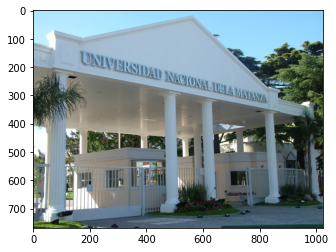

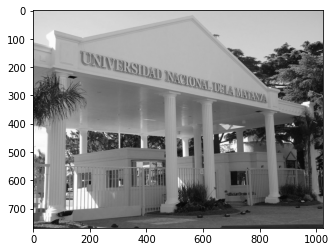

In [ ]:
%matplotlib inline
from datetime import datetime
tiempo_total = datetime.now()

import matplotlib.pyplot as plt
import numpy
from PIL import Image 
import pycuda.driver as cuda
import pycuda.autoinit
from pycuda.compiler import SourceModule

# -----------------------------------------------------------------------------
# Definición de función que transforma el tiempo en  milisegundos 
tiempo_en_ms = lambda dt:(dt.days * 24 * 60 * 60 + dt.seconds) * 1000 + dt.microseconds / 1000.0
# -----------------------------------------------------------------------------

img_nombre = 'imagen.jpg'
image = Image.open( img_nombre ) 
  
# summarize some details about the image 
img_ancho, img_alto  = image.size 

# -----------------------------------------------------------------------------
# Convierto la imagen comprimida en JPEG/PNG a array
img_O_cpu = numpy.asarray(image)
img_O_cpu = img_O_cpu.astype( numpy.int32() )
img_R_cpu = numpy.empty_like( img_O_cpu)

# Reservo los 2 vectores en GPU(3 pixeles usa RGB * (el tamaño del array))
img_O_gpu = cuda.mem_alloc( img_O_cpu.nbytes )
img_R_gpu = cuda.mem_alloc( img_R_cpu.nbytes )

# GPU - Copio la memoria al GPU.
cuda.memcpy_htod( img_O_gpu, img_O_cpu )
cuda.memcpy_htod( img_R_gpu, img_R_cpu )

# -----------------------------------------------------------------------------
# CPU - Defino la función kernel que ejecutará en GPU.
module = SourceModule("""
#define PIXEL_ROJO( x,y) (x+(y*ancho))*3
#define PIXEL_VERDE(x,y) PIXEL_ROJO(x,y) + 1
#define PIXEL_AZUL( x,y) PIXEL_ROJO(x,y) + 2

__global__ void kernel_img( int ancho, int alto, int *img_O, int *img_R )
{
  // Calculo las coordenadas del Thread en dos dimensiones.
  int idx = threadIdx.x + blockIdx.x*blockDim.x;
  int idy = threadIdx.y + blockIdx.y*blockDim.y;
  float fGris = 0.0;

  // Verifico que los Thread, esten dentro de las dimensiones de la imagen.
  if( idx < ancho && idy < alto )
  {
    // Calculo el color gris para el pixel a partir de los componentes.
    fGris = (float)img_O[ PIXEL_ROJO(  idx, idy ) ]*0.29;  // Componente Rojo del pixel.
    fGris +=(float)img_O[ PIXEL_VERDE( idx, idy ) ]*0.59;  // Componente Verde del pixel.
    fGris +=(float)img_O[ PIXEL_AZUL(  idx, idy ) ]*0.11;  // Componente Azul del pixel.
    // Escribo el color del pixel.
    img_R[ PIXEL_ROJO(  idx, idy ) ] = (int) fGris;
    img_R[ PIXEL_VERDE( idx, idy ) ] = (int) fGris;
    img_R[ PIXEL_AZUL(  idx, idy ) ] = (int) fGris;
  }
}
""") 

# -----------------------------------------------------------------------------
# CPU - Genero la función kernel.
kernel = module.get_function("kernel_img")

tiempo_img = datetime.now()

dim_hilo_x = 16
dim_bloque_x = int( (img_ancho+dim_hilo_x-1) / dim_hilo_x )

dim_hilo_y = 19
dim_bloque_y = int( (img_alto+dim_hilo_y-1) / dim_hilo_y )

tiempo_img = datetime.now()

# -----------------------------------------------------------------------------
kernel( numpy.int32(img_ancho), numpy.int32(img_alto), img_O_gpu, img_R_gpu, 
        block=( dim_hilo_x, dim_hilo_y, 1 ), 
        grid=(dim_bloque_x, dim_bloque_y,1) )

tiempo_img = datetime.now() - tiempo_img

# -----------------------------------------------------------------------------
# GPU - Copio el resultado desde la memoria GPU.
cuda.memcpy_dtoh( img_R_cpu, img_R_gpu )

# -----------------------------------------------------------------------------
# Muestro la imagen Original el filtro.
plt.figure()
imgplot=plt.imshow( img_O_cpu )

# Muestro la imagen luego de aplicarle el filtro.
plt.figure()
imgplot=plt.imshow( img_R_cpu )

tiempo_total = datetime.now() - tiempo_total

# -----------------------------------------------------------------------------
# Muestro los atributos de la imagen y como se ve antes del seudo filtro.
print("Imagen del filtro: ", img_nombre , " - tipo " , image.mode , "- [" , img_ancho , ", " , img_alto , "]" )  
print( "Grilla : [", dim_bloque_x, ",", dim_bloque_y, "], Bloques: [", dim_hilo_x, ",", dim_hilo_y, " ] "  )
print( "Total de Thread: [", dim_hilo_x*dim_bloque_x, ",", dim_hilo_y*dim_bloque_y, " ]", " = ", dim_hilo_x*dim_bloque_x*dim_hilo_y*dim_bloque_y )
print("Tiempo TOTAL: ", tiempo_en_ms( tiempo_total ), "[ms]" )
print("Tiempo GPU  : ", tiempo_en_ms( tiempo_img ), "[ms]" )


---
# 5 Conclusiones

Las conclusiones son explicadas en clase...

---
# 6 Bibliografía

[1] MARKDOWN SYNTAX Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[2] Introducción a Python: [Página Colab](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/Python_Basico.ipynb) 

[3] Tutorial Point Colab: [PDF](https://github.com/wvaliente/SOA_HPC/blob/main/Documentos/markdown-cheatsheet-online.pdf)

[4] 2009, SINTESIS DIGITAL DE COLOR UTILIZANDO TONOS DE GRIS, ING. JESÚS GUSTAVO FLORES ERAÑA : [PDF](https://ninive.uaslp.mx/xmlui/bitstream/handle/i/2264/MCA1SDC00901.pdf?sequence=1&isAllowed=y)
